In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [4]:
#importing the main folder and excel file
data_dir = '/content/drive/MyDrive/Eye/'
excel = pd.read_csv(data_dir+'data_information (1).csv')
#dividing it into 3 folders
cnv=excel[(excel['Class']=='CNV') & (excel['Label']=='CNV')]
normal=excel[(excel['Class']=='CNV') & (excel['Label']=='NORMAL')]
drusen = excel[(excel['Class']=='DRUSEN') & (excel['Label']=='DRUSEN')]
#making a sampled dataset which contain 300 images
cnv_subset = cnv.sample(n=400,random_state=42)
normal_subset = normal.sample(n=400,random_state=42)
drusen_subset = drusen.sample(n=400,random_state=42)
sampled_data = pd.concat([cnv_subset, normal_subset, drusen_subset], ignore_index=True)
drusen = pd.concat([normal_subset, drusen_subset], ignore_index=True)
cnv=pd.concat([cnv_subset, normal_subset], ignore_index=True)
both=pd.concat([cnv_subset,drusen_subset], ignore_index=True)

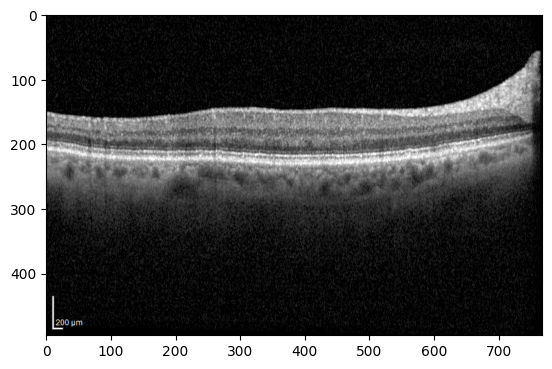

In [3]:
import cv2
images=[]
for i in both['Directory']:
  img = cv2.imread(data_dir+i)
  images.append(img)
plt.imshow(img, cmap='gray')

In [13]:
len(images)
both = pd.concat([cnv_subset, drusen_subset], ignore_index=True)

# **mean** **filter**

In [ ]:
# Load images, apply mean filter, and save the filtered images to a new folder
filtered_images_dir = '/content/drive/MyDrive/Eye/Filtere/'

if not os.path.exists(filtered_images_dir):
    os.makedirs(filtered_images_dir)

for index, row in both.iterrows():
    img_path = data_dir + row['Directory']
    img = cv2.imread(img_path)
    if img is not None:
        # Apply mean filter
        filtered_img = cv2.blur(img, (3, 3))  # Adjust kernel size as needed

        # Save the filtered image to the new folder
        filename = os.path.basename(img_path)
        filtered_img_path = os.path.join(filtered_images_dir, filename)
        cv2.imwrite(filtered_img_path, filtered_img)

        print(f"Filtered image saved: {filtered_img_path}")
    else:
        print(f"Error: Unable to read image '{img_path}'")


In [15]:
import cv2
import numpy as np
import os
from skimage import feature

# Define the directory containing filtered images
filtered_data_dir = '/content/drive/MyDrive/Eye/Filtere/'

# List to store LBP features
lbp_features = []

# Iterate over the rows in the 'Directory' column of the drusen dataframe
for index, row in both.iterrows():
    # Read the filtered image
    filtered_img_path = os.path.join(filtered_data_dir, os.path.basename(row['Directory']))
    filtered_img = cv2.imread(filtered_img_path)

    # Check if the filtered image was successfully loaded
    if filtered_img is not None:
        # Convert the image to grayscale
        gray_img = cv2.cvtColor(filtered_img, cv2.COLOR_BGR2GRAY)

        # Compute LBP features
        lbp = feature.local_binary_pattern(gray_img, P=8, R=1, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)

        # Append LBP features to the list
        lbp_features.append(hist)

# Convert the list of LBP features to a numpy array
lbp_features = np.array(lbp_features)

# Display sample LBP features
print("LBP features shape:", lbp_features.shape)
print("Sample LBP features:")
print(lbp_features[:5])


LBP features shape: (800, 9)
Sample LBP features:
[[0.02060232 0.05063424 0.05409946 0.16545909 0.20698925 0.1567094
  0.09392326 0.05716041 0.19442257]
 [0.02073883 0.04165617 0.05611297 0.17202988 0.25117345 0.17051779
  0.08567236 0.04794869 0.15414987]
 [0.01033791 0.02876659 0.02638556 0.13074387 0.17834866 0.14405084
  0.06223748 0.04172967 0.3773994 ]
 [0.0144568  0.03178816 0.03989205 0.14087964 0.1956564  0.134784
  0.07071415 0.03781817 0.33401063]
 [0.02863796 0.05912403 0.06836988 0.16891906 0.21757655 0.1577831
  0.09413327 0.06282552 0.14263063]]


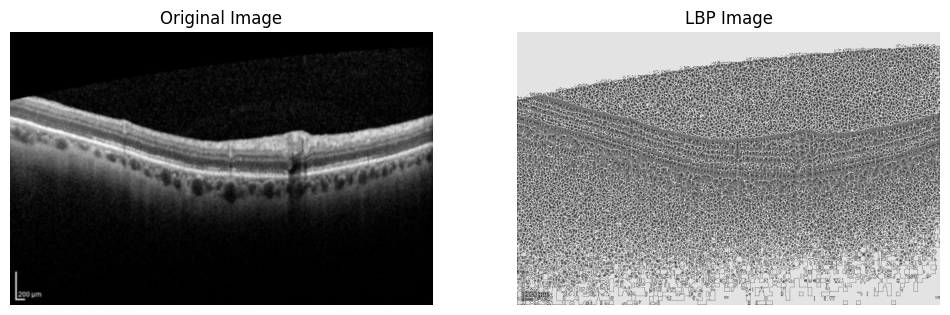

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature

# Specify the filename of the image to display
filename = '/content/drive/MyDrive/Filtered/000_Drusen.jpg'  # Change this to the actual filename you want to display

# Paths for the original and filtered image
original_img_path = os.path.join(data_dir, filename)
filtered_img_path = os.path.join(filtered_data_dir, filename)

# Load the original image in grayscale
original_img = cv2.imread(original_img_path, cv2.IMREAD_GRAYSCALE)
if original_img is None:
    print("Failed to load the original image.")
    exit()

# Load the filtered image in grayscale
filtered_img = cv2.imread(filtered_img_path, cv2.IMREAD_GRAYSCALE)
if filtered_img is None:
    print("Failed to load the filtered image.")
    exit()

# Compute LBP features
lbp = feature.local_binary_pattern(filtered_img, P=8, R=1, method='uniform')

# Display the original and LBP images side by side
plt.figure(figsize=(12, 6))

# Display original image
plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Display LBP image
plt.subplot(1, 2, 2)
plt.imshow(lbp, cmap='gray')
plt.title('LBP Image')
plt.axis('off')

plt.show()


In [17]:
# Assuming you have your target vector y as a pandas Series
y = both['Label']

# Encode the target vector
# Assign 0 for DRUSEN, 1 for CNV, and 2 for NORMAL
y_encoded = y.map({'DRUSEN': 0, 'CNV': 1})
X = lbp_features

In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="linear")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.525   0.475   0.45    0.43125 0.53125]
Mean Accuracy: 0.48250000000000004


In [20]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the Logistic Regression classifier
logistic_regression_classifier = LogisticRegression()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_lr = cross_val_score(logistic_regression_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Logistic Regression:", cv_scores_lr)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_lr = cv_scores_lr.mean()
std_dev_accuracy_lr = cv_scores_lr.std()
print("Mean Accuracy with Logistic Regression:", mean_accuracy_lr)
print("Standard Deviation of Accuracy with Logistic Regression:", std_dev_accuracy_lr)

Cross-validation scores with Logistic Regression: [0.6375  0.50625 0.5     0.43125 0.5375 ]
Mean Accuracy with Logistic Regression: 0.5225
Standard Deviation of Accuracy with Logistic Regression: 0.06715188009281645


In [21]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier

# Define the number of neighbors for KNN
num_neighbors = 5

# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=num_neighbors)

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_knn = cross_val_score(knn_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with KNN:", cv_scores_knn)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_knn = cv_scores_knn.mean()
std_dev_accuracy_knn = cv_scores_knn.std()
print("Mean Accuracy with KNN:", mean_accuracy_knn)
print("Standard Deviation of Accuracy with KNN:", std_dev_accuracy_knn)

Cross-validation scores with KNN: [0.9375  0.93125 0.9625  0.94375 0.9    ]
Mean Accuracy with KNN: 0.9349999999999999
Standard Deviation of Accuracy with KNN: 0.02038688303787511


In [22]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB

# Initialize the Naive Bayes classifier (Gaussian Naive Bayes)
nb_classifier = GaussianNB()

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_nb = cross_val_score(nb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Naive Bayes:", cv_scores_nb)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_nb = cv_scores_nb.mean()
std_dev_accuracy_nb = cv_scores_nb.std()
print("Mean Accuracy with Naive Bayes:", mean_accuracy_nb)
print("Standard Deviation of Accuracy with Naive Bayes:", std_dev_accuracy_nb)

Cross-validation scores with Naive Bayes: [0.59375 0.46875 0.61875 0.54375 0.5875 ]
Mean Accuracy with Naive Bayes: 0.5624999999999999
Standard Deviation of Accuracy with Naive Bayes: 0.05273755777432248


In [23]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(xgb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with XGBoost:", cv_scores)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy = cv_scores.mean()
std_dev_accuracy = cv_scores.std()
print("Mean Accuracy with XGBoost:", mean_accuracy)
print("Standard Deviation of Accuracy with XGBoost:", std_dev_accuracy)

Cross-validation scores with XGBoost: [0.9875 0.9875 0.9875 0.9875 0.975 ]
Mean Accuracy with XGBoost: 0.985
Standard Deviation of Accuracy with XGBoost: 0.005000000000000026


In [24]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
num_folds = 5

# Initialize the SVM classifier
svm_classifier = SVC(kernel='sigmoid')

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy = cv_scores.mean()
std_dev_accuracy = cv_scores.std()
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_dev_accuracy)

Cross-validation scores: [0.43125 0.475   0.45    0.43125 0.49375]
Mean Accuracy: 0.45625
Standard Deviation of Accuracy: 0.02468552207266437


Gamma: 0.001, Mean Accuracy: 0.475
Gamma: 0.01, Mean Accuracy: 0.475
Gamma: 0.1, Mean Accuracy: 0.475
Gamma: 1, Mean Accuracy: 0.49124999999999996
Gamma: 10, Mean Accuracy: 0.64625


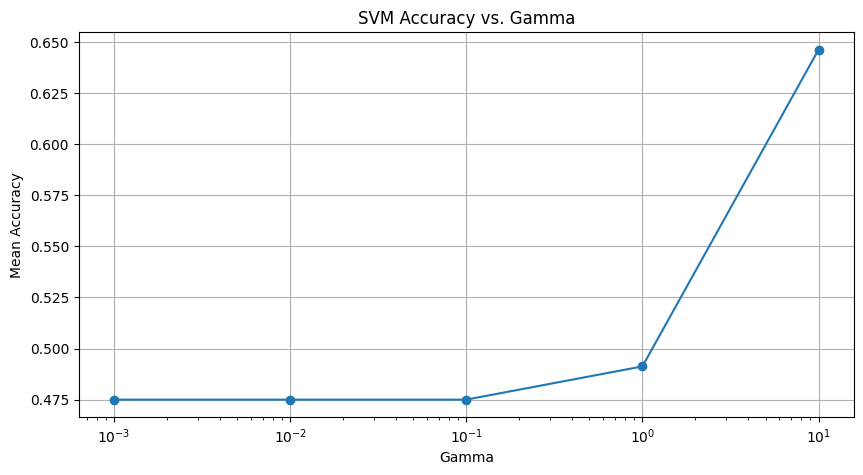

In [25]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying gamma values
gamma_values = [0.001, 0.01, 0.1, 1, 10]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each gamma
mean_accuracies = []

# Loop through each gamma value, train the SVM and calculate cross-validation scores
for gamma in gamma_values:
    svm_classifier = SVC(kernel="rbf", gamma=gamma)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Gamma: {gamma}, Mean Accuracy: {mean_accuracy}")

# You could also plot these to see how gamma affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(gamma_values, mean_accuracies, marker='o')
plt.xlabel('Gamma')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Gamma')
plt.xscale('log')  # Since gamma values vary in orders of magnitude, log scale might be more informative
plt.grid(True)
plt.show()

Degree: 1, Cross-validation scores: [0.58125 0.575   0.6625  0.4875  0.5875 ]
Degree: 1, Mean Accuracy: 0.57875
Degree: 2, Cross-validation scores: [0.575   0.65625 0.73125 0.59375 0.65625]
Degree: 2, Mean Accuracy: 0.6425
Degree: 3, Cross-validation scores: [0.61875 0.7375  0.75    0.5875  0.68125]
Degree: 3, Mean Accuracy: 0.675
Degree: 4, Cross-validation scores: [0.65    0.74375 0.74375 0.6875  0.6875 ]
Degree: 4, Mean Accuracy: 0.7025
Degree: 5, Cross-validation scores: [0.70625 0.80625 0.78125 0.725   0.74375]
Degree: 5, Mean Accuracy: 0.7525000000000001


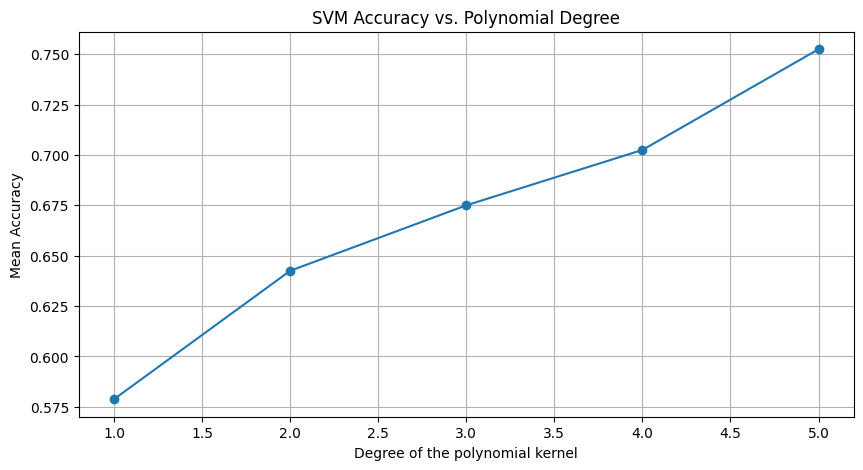

In [26]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying degrees
degree_values = [1, 2, 3, 4, 5]  # Different degrees of the polynomial to test
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each degree
mean_accuracies = []

# Loop through each degree value, train the SVM and calculate cross-validation scores
for degree in degree_values:
    svm_classifier = SVC(kernel="poly", degree=degree)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Degree: {degree}, Cross-validation scores: {cv_scores}")
    print(f"Degree: {degree}, Mean Accuracy: {mean_accuracy}")

# Optionally, you could plot these to visualize how the degree affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(degree_values, mean_accuracies, marker='o')
plt.xlabel('Degree of the polynomial kernel')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Polynomial Degree')
plt.grid(True)
plt.show()

# **guassian**

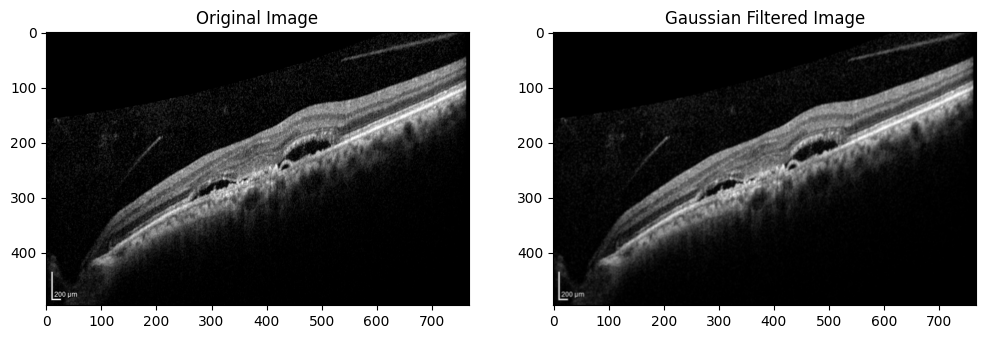

Directory /content/drive/MyDrive/GaussianFil/012_Drusen.tif could not be accessed or does not exist.


In [27]:
import cv2
import os
import matplotlib.pyplot as plt

# Define your base directory and new directory for the filtered images
data_dir = '/content/drive/MyDrive/Eye/'
filtered_dir = '/content/drive/MyDrive/GaussianFil'

# Create the filtered images directory if it doesn't already exist
if not os.path.exists(filtered_dir):
    os.makedirs(filtered_dir)

for idx, entry in both.iterrows():
    img_path = os.path.join(data_dir, entry['Directory'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        # Apply Gaussian Blur
        filtered_img = cv2.GaussianBlur(img, (3, 3), 0)

        # Save the filtered image
        save_path = os.path.join(filtered_dir, os.path.basename(entry['Directory']))
        cv2.imwrite(save_path, filtered_img)

        # Optionally, show the first image's original and filtered version for verification
        if idx == 0:
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(img, cmap='gray')
            plt.title('Original Image')
            plt.subplot(1, 2, 2)
            plt.imshow(filtered_img, cmap='gray')
            plt.title('Gaussian Filtered Image')
            plt.show()
    else:
        print(f"Failed to load image at {img_path}")
else:
    print(f"Directory {save_path} could not be accessed or does not exist.")


In [29]:
import cv2
import numpy as np
import os
from skimage import feature
filtered_data_dir = '/content/drive/MyDrive/GaussianFil'
# List to store LBP features
lbp_features = []

# Iterate over the rows in the 'Directory' column of cnv
for index, row in both.iterrows():
    # Read the filtered image
    filtered_img_path = os.path.join(filtered_data_dir, os.path.basename(row['Directory']))
    filtered_img = cv2.imread(filtered_img_path)

    # Check if the filtered image was successfully loaded
    if filtered_img is not None:
        # Convert the image to grayscale
        gray_img = cv2.cvtColor(filtered_img, cv2.COLOR_BGR2GRAY)

        # Compute LBP features
        lbp = feature.local_binary_pattern(gray_img, P=8, R=1, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)

        # Append LBP features to the list
        lbp_features.append(hist)

# Convert the list of LBP features to a numpy array
lbp_features = np.array(lbp_features)


# Display sample LBP features
print("LBP features shape:", lbp_features.shape)
print("Sample LBP features:")
print(lbp_features[:5])

LBP features shape: (800, 9)
Sample LBP features:
[[0.0261283  0.05199408 0.06008747 0.15735782 0.21131552 0.15384272
  0.09011677 0.05607884 0.19307848]
 [0.02663233 0.04593782 0.06259713 0.16659579 0.2312773  0.16232989
  0.08819252 0.05098864 0.16544859]
 [0.01481382 0.03388829 0.03325038 0.1273574  0.17298807 0.13277312
  0.06368658 0.0414304  0.37981193]
 [0.01961001 0.03542664 0.04569105 0.13561355 0.1832131  0.12815283
  0.07236276 0.03978705 0.34014302]
 [0.03316375 0.05806084 0.07190598 0.16352172 0.22055612 0.15827925
  0.09110121 0.0601216  0.14328955]]


In [ ]:
# Display sample LBP features
print("LBP features shape:", lbp_features.shape)
print("Sample LBP features:")
print(lbp_features[:5])

In [30]:
# Assuming you have your target vector y as a pandas Series
y = both['Label']

# Encode the target vector
# Assign 0 for DRUSEN, 1 for CNV, and 2 for NORMAL
y_encoded = y.map({'DRUSEN': 0, 'CNV': 1})
X = lbp_features

In [31]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="linear")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.525   0.475   0.45    0.43125 0.49375]
Mean Accuracy: 0.475


In [32]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="rbf")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.56875 0.65    0.61875 0.60625 0.63125]
Mean Accuracy: 0.615


In [33]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="sigmoid")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.475   0.475   0.45    0.43125 0.49375]
Mean Accuracy: 0.46499999999999997


Gamma: 0.001, Mean Accuracy: 0.475
Gamma: 0.01, Mean Accuracy: 0.475
Gamma: 0.1, Mean Accuracy: 0.47124999999999995
Gamma: 1, Mean Accuracy: 0.4887499999999999
Gamma: 10, Mean Accuracy: 0.6050000000000001


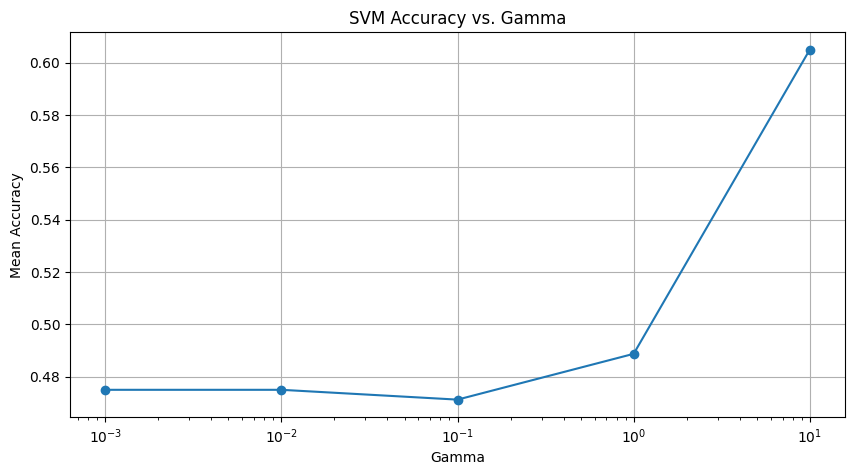

In [34]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying gamma values
gamma_values = [0.001, 0.01, 0.1, 1, 10]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each gamma
mean_accuracies = []

# Loop through each gamma value, train the SVM and calculate cross-validation scores
for gamma in gamma_values:
    svm_classifier = SVC(kernel="rbf", gamma=gamma)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Gamma: {gamma}, Mean Accuracy: {mean_accuracy}")

# You could also plot these to see how gamma affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(gamma_values, mean_accuracies, marker='o')
plt.xlabel('Gamma')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Gamma')
plt.xscale('log')  # Since gamma values vary in orders of magnitude, log scale might be more informative
plt.grid(True)
plt.show()

Degree: 1, Cross-validation scores: [0.55625 0.49375 0.45    0.43125 0.575  ]
Degree: 1, Mean Accuracy: 0.50125
Degree: 2, Cross-validation scores: [0.61875 0.7125  0.625   0.63125 0.65625]
Degree: 2, Mean Accuracy: 0.6487499999999999
Degree: 3, Cross-validation scores: [0.65    0.7     0.70625 0.5875  0.69375]
Degree: 3, Mean Accuracy: 0.6675000000000001
Degree: 4, Cross-validation scores: [0.675   0.78125 0.76875 0.61875 0.66875]
Degree: 4, Mean Accuracy: 0.7025
Degree: 5, Cross-validation scores: [0.6875  0.74375 0.7625  0.675   0.70625]
Degree: 5, Mean Accuracy: 0.7149999999999999


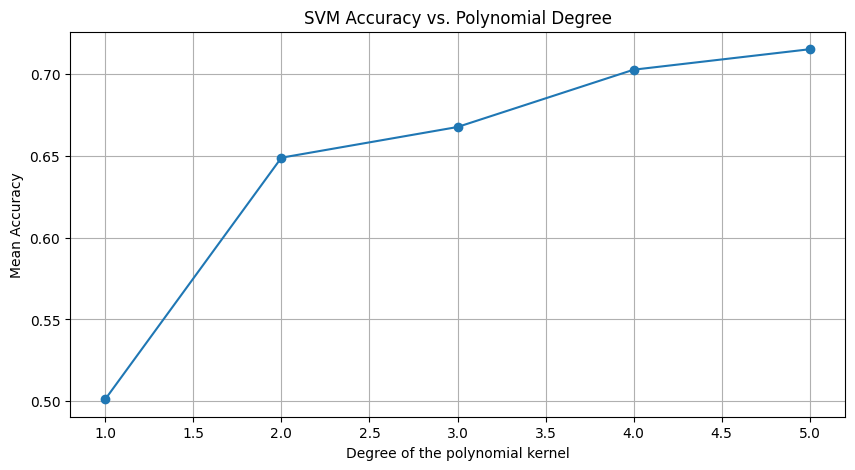

In [35]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying degrees
degree_values = [1, 2, 3, 4, 5]  # Different degrees of the polynomial to test
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each degree
mean_accuracies = []

# Loop through each degree value, train the SVM and calculate cross-validation scores
for degree in degree_values:
    svm_classifier = SVC(kernel="poly", degree=degree)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Degree: {degree}, Cross-validation scores: {cv_scores}")
    print(f"Degree: {degree}, Mean Accuracy: {mean_accuracy}")

# Optionally, you could plot these to visualize how the degree affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(degree_values, mean_accuracies, marker='o')
plt.xlabel('Degree of the polynomial kernel')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Polynomial Degree')
plt.grid(True)
plt.show()

In [36]:
# Define your SVM classifier
svm_classifier = SVC(kernel="sigmoid")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.475   0.475   0.45    0.43125 0.49375]
Mean Accuracy: 0.46499999999999997


In [37]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the Logistic Regression classifier
logistic_regression_classifier = LogisticRegression()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_lr = cross_val_score(logistic_regression_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Logistic Regression:", cv_scores_lr)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_lr = cv_scores_lr.mean()
std_dev_accuracy_lr = cv_scores_lr.std()
print("Mean Accuracy with Logistic Regression:", mean_accuracy_lr)
print("Standard Deviation of Accuracy with Logistic Regression:", std_dev_accuracy_lr)

Cross-validation scores with Logistic Regression: [0.60625 0.4125  0.49375 0.45625 0.525  ]
Mean Accuracy with Logistic Regression: 0.49874999999999997
Standard Deviation of Accuracy with Logistic Regression: 0.06559820881700963


In [38]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier

# Define the number of neighbors for KNN
num_neighbors = 5

# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=num_neighbors)

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_knn = cross_val_score(knn_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with KNN:", cv_scores_knn)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_knn = cv_scores_knn.mean()
std_dev_accuracy_knn = cv_scores_knn.std()
print("Mean Accuracy with KNN:", mean_accuracy_knn)
print("Standard Deviation of Accuracy with KNN:", std_dev_accuracy_knn)

Cross-validation scores with KNN: [0.9375  0.9375  0.95625 0.9375  0.925  ]
Mean Accuracy with KNN: 0.93875
Standard Deviation of Accuracy with KNN: 0.010000000000000004


In [39]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB

# Initialize the Naive Bayes classifier (Gaussian Naive Bayes)
nb_classifier = GaussianNB()

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_nb = cross_val_score(nb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Naive Bayes:", cv_scores_nb)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_nb = cv_scores_nb.mean()
std_dev_accuracy_nb = cv_scores_nb.std()
print("Mean Accuracy with Naive Bayes:", mean_accuracy_nb)
print("Standard Deviation of Accuracy with Naive Bayes:", std_dev_accuracy_nb)

Cross-validation scores with Naive Bayes: [0.525   0.4625  0.53125 0.5     0.5125 ]
Mean Accuracy with Naive Bayes: 0.50625
Standard Deviation of Accuracy with Naive Bayes: 0.024366985862022402


In [40]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(xgb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with XGBoost:", cv_scores)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy = cv_scores.mean()
std_dev_accuracy = cv_scores.std()
print("Mean Accuracy with XGBoost:", mean_accuracy)
print("Standard Deviation of Accuracy with XGBoost:", std_dev_accuracy)

Cross-validation scores with XGBoost: [0.9875  0.9875  0.9875  0.9875  0.96875]
Mean Accuracy with XGBoost: 0.98375
Standard Deviation of Accuracy with XGBoost: 0.007500000000000018


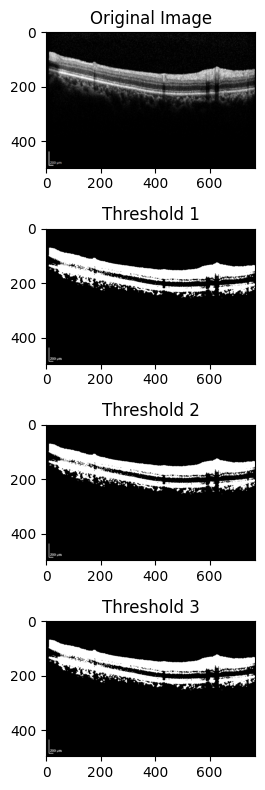

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to perform multilevel thresholding using Otsu's method
def multilevel_thresholding(image, num_thresholds):
    # Convert the image to grayscale
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Otsu's thresholding to find the initial threshold
    _, initial_threshold = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Initialize the thresholds list with the initial threshold
    thresholds = [initial_threshold]

    # Calculate additional thresholds based on the initial threshold
    for _ in range(num_thresholds - 1):
        # Use the previous threshold as a mask to exclude pixels that have already been segmented
        masked_img = cv2.bitwise_and(gray_img, initial_threshold)

        # Apply Otsu's thresholding to find the next threshold
        _, threshold = cv2.threshold(masked_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Add the new threshold to the list
        thresholds.append(threshold)

        # Update the initial threshold by bitwise OR operation with the new threshold
        initial_threshold = cv2.bitwise_or(initial_threshold, threshold)

    return thresholds

# Select a random image from the dataset
idx = np.random.randint(len(cnv))
img_path = os.path.join(data_dir, cnv['Directory'].iloc[idx])
img = cv2.imread(img_path)

# Perform multilevel thresholding with 3 thresholds
num_thresholds = 3
thresholds = multilevel_thresholding(img, num_thresholds)

# Plot the original image and the thresholded images
plt.figure(figsize=(12, 8))
plt.subplot(num_thresholds + 1, 1, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

for i in range(num_thresholds):
    plt.subplot(num_thresholds + 1, 1, i + 2)
    plt.imshow(thresholds[i], cmap='gray')
    plt.title(f'Threshold {i+1}')

plt.tight_layout()
plt.show()

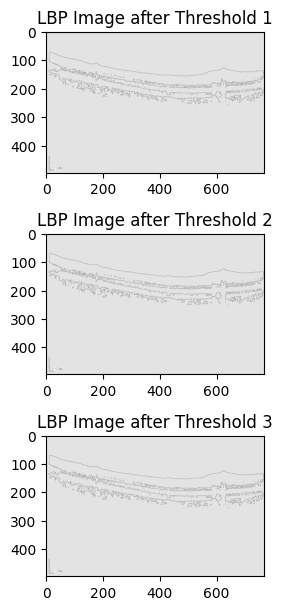

In [42]:
from skimage.feature import local_binary_pattern

# Function to apply LBP
def apply_lbp(image):
    # Compute LBP
    radius = 1
    n_points = 8 * radius
    lbp_image = local_binary_pattern(image, n_points, radius, method='uniform')
    return lbp_image

# Apply LBP to each thresholded image
lbp_images = [apply_lbp(threshold) for threshold in thresholds]

# Plot the LBP images
plt.figure(figsize=(12, 8))
for i, lbp_image in enumerate(lbp_images):
    plt.subplot(num_thresholds + 1, 1, i + 2)
    plt.imshow(lbp_image, cmap='gray')
    plt.title(f'LBP Image after Threshold {i+1}')

plt.tight_layout()
plt.show()

# **filetring**

In [7]:
import cv2
import numpy as np
import os
from skimage import io  # Used for reading images if cv2 fails

# Define directories
data_dir = '/content/drive/MyDrive/Eye/'
save_dir = '/content/drive/MyDrive/Multilevel'

# Ensure the save directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Function to apply multilevel thresholding using k-means clustering
def multilevel_thresholding(image_path, k=3):
    # Read the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        img = io.imread(image_path, as_gray=True)  # Fallback using skimage
        if img is None:
            return None
        img = (img * 255).astype(np.uint8)  # skimage returns [0,1] float image

    # Reshape the image to a 2D array of pixels
    Z = img.reshape((-1, 1))

    # Convert to float
    Z = np.float32(Z)

    # Define criteria and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    ret, label, center = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert back into uint8, and make original image shape
    center = np.uint8(center)
    res = center[label.flatten()]
    segmented_image = res.reshape((img.shape))

    return segmented_image

# Apply multilevel thresholding to each image in the sampled dataset
for idx, row in both.iterrows():
    image_path = os.path.join(data_dir, row['Directory'])
    result_image = multilevel_thresholding(image_path, k=3)  # Set k to the desired number of levels

    if result_image is not None:
        # Save the processed image
        save_path = os.path.join(save_dir, os.path.basename(row['Directory']))
        cv2.imwrite(save_path, result_image)
    else:
        print(f"Failed to load/process image: {row['Directory']}")

print("All images processed and saved to", save_dir)


All images processed and saved to /content/drive/MyDrive/Multilevel


Number of images in the MultilevelThresholdedImages directory: 116


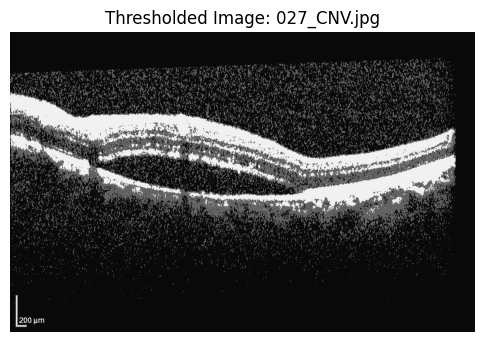

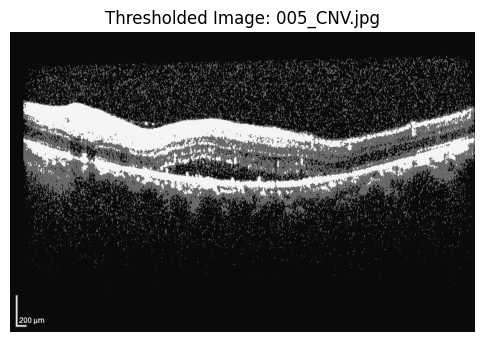

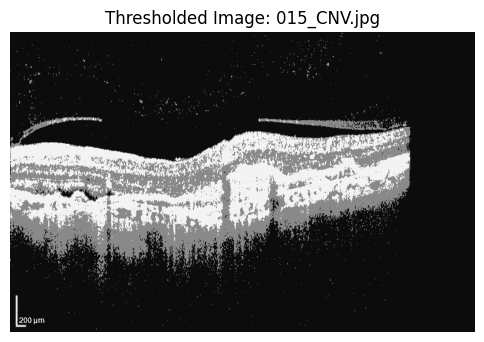

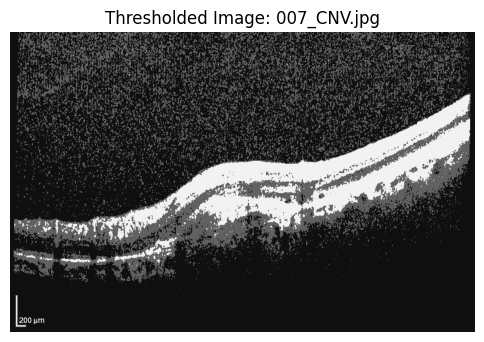

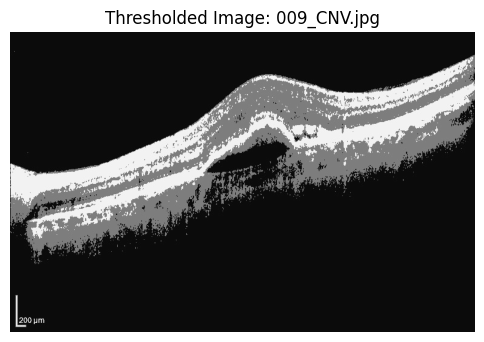

In [8]:
import os
import matplotlib.pyplot as plt
import cv2

# Define the directory containing the thresholded images
thresholded_dir = '/content/drive/MyDrive/Multilevel'

# Get the list of images
image_files = [img for img in os.listdir(thresholded_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp', '.gif'))]

# Count the number of images
num_images = len(image_files)

print(f"Number of images in the MultilevelThresholdedImages directory: {num_images}")

# Display the first 5 images
for img in image_files[:5]:
    img_path = os.path.join(thresholded_dir, img)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(f"Thresholded Image: {img}")
    plt.axis('off')
    plt.show()


In [9]:
import cv2
import numpy as np
import os
from skimage import feature

# Define the directory containing the filtered images
filtered_data_dir = '/content/drive/MyDrive/Multilevel'

# List to store LBP features
lbp_features = []

# Iterate over the rows in the 'Directory' column of cnv
for index, row in both.iterrows():
    # Read the filtered image
    filtered_img_path = os.path.join(filtered_data_dir, os.path.basename(row['Directory']))
    filtered_img = cv2.imread(filtered_img_path)

    # Check if the filtered image was successfully loaded
    if filtered_img is not None:
        # Convert the image to grayscale
        gray_img = cv2.cvtColor(filtered_img, cv2.COLOR_BGR2GRAY)

        # Compute LBP features
        lbp = feature.local_binary_pattern(gray_img, P=8, R=1, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)

        # Append LBP features to the list
        lbp_features.append(hist)

# Convert the list of LBP features to a numpy array
lbp_features = np.array(lbp_features)

# Display sample LBP features
print("LBP features shape:", lbp_features.shape)
print("Sample LBP features:")
print(lbp_features[:5])

LBP features shape: (800, 9)
Sample LBP features:
[[1.21807796e-03 7.01969926e-03 2.62516801e-06 1.22201571e-02
  2.62516801e-05 3.17514071e-02 5.25033602e-06 1.43334173e-02
  9.33423114e-01]
 [3.69098622e-03 1.08130670e-02 5.25033602e-06 1.67931998e-02
  2.23139281e-04 3.97056662e-02 2.33639953e-04 1.88933342e-02
  9.09641717e-01]
 [4.83030914e-04 2.35740087e-03 2.62516801e-06 8.68930612e-03
  5.77536962e-05 2.39651588e-02 4.20026882e-05 9.92576025e-03
  9.54476962e-01]
 [1.20757728e-03 6.13239247e-03 5.25033602e-06 1.43649194e-02
  2.15263777e-04 3.21215558e-02 2.15263777e-04 1.42205351e-02
  9.31517242e-01]
 [1.01173975e-02 5.04951067e-02 1.57510081e-05 3.44789567e-02
  1.78511425e-04 5.52965390e-02 6.22164819e-04 2.36711400e-02
  8.25124433e-01]]


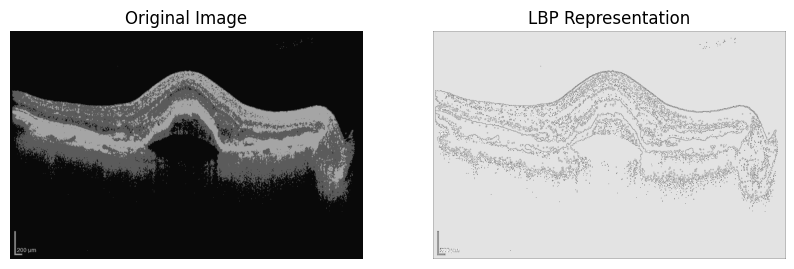

In [10]:
import cv2
import os
from skimage import feature
import matplotlib.pyplot as plt

# Function to compute LBP features for an image
def compute_lbp(image):
    # Convert the image to grayscale
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute LBP features
    lbp = feature.local_binary_pattern(gray_img, P=8, R=1, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    return lbp, hist

# Choose an image from the dataset (you can change the index as needed)
image_index = 0
filtered_img_path = os.path.join(filtered_data_dir, os.path.basename(cnv.iloc[image_index]['Directory']))
filtered_img = cv2.imread(filtered_img_path)

# Compute LBP features for the chosen image
lbp, hist = compute_lbp(filtered_img)

# Plot the original image and its LBP representation
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(filtered_img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# LBP representation
plt.subplot(1, 2, 2)
plt.imshow(lbp, cmap='gray')
plt.title('LBP Representation')
plt.axis('off')

plt.show()

In [11]:
# Assuming you have your target vector y as a pandas Series
y = both['Label']

# Encode the target vector
# Assign 0 for DRUSEN, 1 for CNV, and 2 for NORMAL
y_encoded = y.map({'DRUSEN': 0, 'CNV': 1})
X = lbp_features

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="linear")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.50625 0.475   0.45    0.43125 0.49375]
Mean Accuracy: 0.47124999999999995


In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="sigmoid")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.5     0.475   0.45    0.43125 0.49375]
Mean Accuracy: 0.47000000000000003


Degree: 1, Cross-validation scores: [0.50625 0.475   0.45    0.43125 0.49375]
Degree: 1, Mean Accuracy: 0.47124999999999995
Degree: 2, Cross-validation scores: [0.525   0.475   0.4375  0.43125 0.49375]
Degree: 2, Mean Accuracy: 0.4725
Degree: 3, Cross-validation scores: [0.5375  0.475   0.44375 0.43125 0.49375]
Degree: 3, Mean Accuracy: 0.47624999999999995
Degree: 4, Cross-validation scores: [0.53125 0.49375 0.4375  0.43125 0.49375]
Degree: 4, Mean Accuracy: 0.4774999999999999
Degree: 5, Cross-validation scores: [0.5375  0.4875  0.45    0.43125 0.525  ]
Degree: 5, Mean Accuracy: 0.48624999999999996


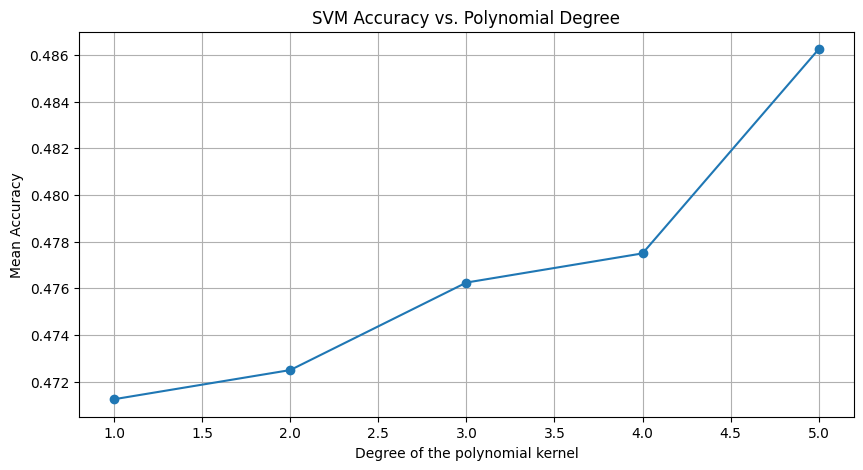

In [14]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying degrees
degree_values = [1, 2, 3, 4, 5]  # Different degrees of the polynomial to test
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each degree
mean_accuracies = []

# Loop through each degree value, train the SVM and calculate cross-validation scores
for degree in degree_values:
    svm_classifier = SVC(kernel="poly", degree=degree)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Degree: {degree}, Cross-validation scores: {cv_scores}")
    print(f"Degree: {degree}, Mean Accuracy: {mean_accuracy}")

# Optionally, you could plot these to visualize how the degree affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(degree_values, mean_accuracies, marker='o')
plt.xlabel('Degree of the polynomial kernel')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Polynomial Degree')
plt.grid(True)
plt.show()

Gamma: 0.001, Mean Accuracy: 0.47124999999999995
Gamma: 0.01, Mean Accuracy: 0.47124999999999995
Gamma: 0.1, Mean Accuracy: 0.47124999999999995
Gamma: 1, Mean Accuracy: 0.4725
Gamma: 10, Mean Accuracy: 0.4625


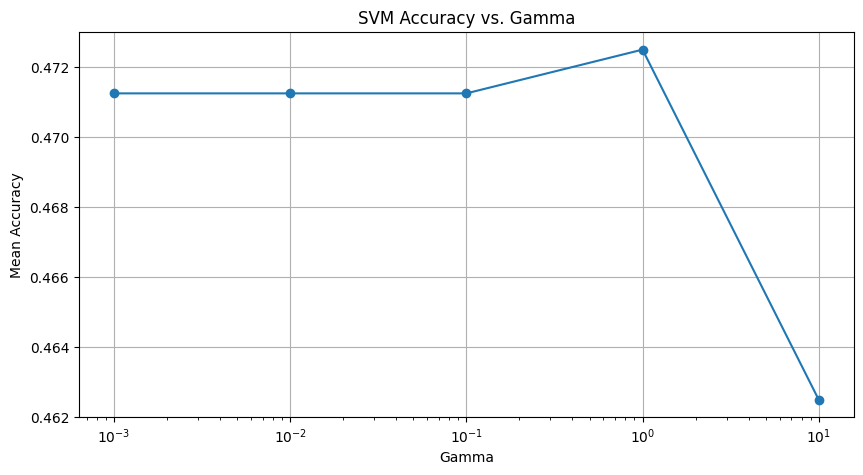

In [15]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying gamma values
gamma_values = [0.001, 0.01, 0.1, 1, 10]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each gamma
mean_accuracies = []

# Loop through each gamma value, train the SVM and calculate cross-validation scores
for gamma in gamma_values:
    svm_classifier = SVC(kernel="rbf", gamma=gamma)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Gamma: {gamma}, Mean Accuracy: {mean_accuracy}")

# You could also plot these to see how gamma affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(gamma_values, mean_accuracies, marker='o')
plt.xlabel('Gamma')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Gamma')
plt.xscale('log')  # Since gamma values vary in orders of magnitude, log scale might be more informative
plt.grid(True)
plt.show()

In [16]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the Logistic Regression classifier
logistic_regression_classifier = LogisticRegression()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_lr = cross_val_score(logistic_regression_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Logistic Regression:", cv_scores_lr)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_lr = cv_scores_lr.mean()
std_dev_accuracy_lr = cv_scores_lr.std()
print("Mean Accuracy with Logistic Regression:", mean_accuracy_lr)
print("Standard Deviation of Accuracy with Logistic Regression:", std_dev_accuracy_lr)

Cross-validation scores with Logistic Regression: [0.49375 0.49375 0.4375  0.43125 0.55   ]
Mean Accuracy with Logistic Regression: 0.48125
Standard Deviation of Accuracy with Logistic Regression: 0.04348131782731522


In [17]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier

# Define the number of neighbors for KNN
num_neighbors = 5

# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=num_neighbors)

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_knn = cross_val_score(knn_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with KNN:", cv_scores_knn)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_knn = cv_scores_knn.mean()
std_dev_accuracy_knn = cv_scores_knn.std()
print("Mean Accuracy with KNN:", mean_accuracy_knn)
print("Standard Deviation of Accuracy with KNN:", std_dev_accuracy_knn)

Cross-validation scores with KNN: [0.94375 0.95625 0.95    0.90625 0.90625]
Mean Accuracy with KNN: 0.9324999999999999
Standard Deviation of Accuracy with KNN: 0.021794494717703367


In [18]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB

# Initialize the Naive Bayes classifier (Gaussian Naive Bayes)
nb_classifier = GaussianNB()

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_nb = cross_val_score(nb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Naive Bayes:", cv_scores_nb)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_nb = cv_scores_nb.mean()
std_dev_accuracy_nb = cv_scores_nb.std()
print("Mean Accuracy with Naive Bayes:", mean_accuracy_nb)
print("Standard Deviation of Accuracy with Naive Bayes:", std_dev_accuracy_nb)

Cross-validation scores with Naive Bayes: [0.5375  0.5     0.45625 0.5625  0.4875 ]
Mean Accuracy with Naive Bayes: 0.50875
Standard Deviation of Accuracy with Naive Bayes: 0.03741657386773942


In [19]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(xgb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with XGBoost:", cv_scores)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy = cv_scores.mean()
std_dev_accuracy = cv_scores.std()
print("Mean Accuracy with XGBoost:", mean_accuracy)
print("Standard Deviation of Accuracy with XGBoost:", std_dev_accuracy)

Cross-validation scores with XGBoost: [0.99375 0.99375 0.99375 0.99375 0.975  ]
Mean Accuracy with XGBoost: 0.99
Standard Deviation of Accuracy with XGBoost: 0.007500000000000018
